Part 1 - Data Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
# Importing the training set
dataset_ts = pd.read_csv('/content/drive/MyDrive/Datasets/FRED-NROUST.csv')

dataset_ts.head()

,Date,Value
0,01-01-1949,5.255053
1,01-04-1949,5.261516
2,01-07-1949,5.268013
3,01-10-1949,5.274564
4,01-01-1950,5.281182


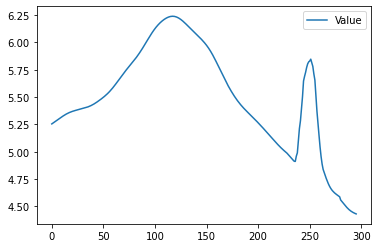

In [3]:
dataset_ts.plot()
plt.show()

In [4]:
dataset_ts.shape

(296, 2)

In [5]:
dataset_train = dataset_ts.iloc[:288,:]
dataset_train.shape

(288, 2)

In [6]:
training_set = dataset_train.iloc[:, 1].values
training_set[:5]

array([5.25505257, 5.26151562, 5.268013  , 5.274564  , 5.281182  ])

In [7]:
training_set.shape

(288,)

Feature Scaling

In [8]:
training_set = training_set.reshape(-1,1)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

In [9]:
training_set_scaled[:5]

array([[0.44014855],
       [0.44382247],
       [0.4475159 ],
       [0.45123982],
       [0.45500182]])

Creating a data structure with timesteps and 1 output

In [10]:
timesteps=5
trn_size = dataset_train.shape[0]
trn_size

288

In [11]:
X_train = []
y_train = []
for i in range(timesteps, trn_size):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [12]:
X_train.shape

(283, 5)

In [13]:
X_train[:1]

array([[0.44014855, 0.44382247, 0.4475159 , 0.45123982, 0.45500182]])

In [14]:
y_train[:5]

array([0.45880133, 0.46263155, 0.46647597, 0.47031073, 0.4741057 ])

In [15]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(283, 5, 1)

Part 2 - Building the RNN

In [16]:
import tensorflow as tf
from tensorflow import keras

In [17]:
(X_train.shape[1],X_train.shape[2])

(5, 1)

Initialising the RNN

In [18]:
tf.random.set_seed(seed=2022)
model = keras.Sequential([
   tf.keras.layers.LSTM(units=100,return_sequences = True, 
                            input_shape= (X_train.shape[1],X_train.shape[2]) ),
   tf.keras.layers.LSTM(units=70,return_sequences = True ) ,
   tf.keras.layers.LSTM(units=50 ) ,
   tf.keras.layers.Dense(1)                           
])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 5, 70)             47880     
                                                                 
 lstm_2 (LSTM)               (None, 50)                24200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 112,931
Trainable params: 112,931
Non-trainable params: 0
_________________________________________________________________


Fitting the RNN to the Training set

In [20]:
model.fit(X_train, y_train, epochs = 50, batch_size = 25)

Epoch 1/50
12/12 [==============================] - 9s 8ms/step - loss: 0.2336
Epoch 2/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0328
Epoch 3/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0233
Epoch 4/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 7/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 8/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 9/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 10/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 11/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 12/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 13/50
12/12 [==============================

Part 3 - Making the predictions and visualising the results

In [21]:
dataset_test = dataset_ts.iloc[288:,:]
test_set = dataset_test.iloc[:, 1].values
test_set.shape

(8,)

In [22]:
dataset_total = pd.concat((dataset_train['Value'], dataset_test['Value']), axis = 0)
dataset_total

0      5.255053
1      5.261516
2      5.268013
3      5.274564
4      5.281182
         ...   
291    4.450651
292    4.445137
293    4.440214
294    4.435784
295    4.431760
Name: Value, Length: 296, dtype: float64

In [23]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1,1)
len(inputs)

13

In [24]:
inputs = sc.transform(inputs)
X_test = []
for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8, 5, 1)

In [25]:
predicted_values = model.predict(X_test)
predicted_values

1/1 [==============================] - 1s 991ms/step


array([[ 0.00885722],
       [ 0.00287886],
       [-0.0027265 ],
       [-0.00786747],
       [-0.01250178],
       [-0.01663144],
       [-0.0202907 ],
       [-0.02353137]], dtype=float32)

In [26]:
predicted_values.shape

(8, 1)

In [27]:
predicted_values = sc.inverse_transform(predicted_values)
predicted_values

array([[4.4963374],
       [4.485821 ],
       [4.47596  ],
       [4.4669156],
       [4.4587636],
       [4.4514985],
       [4.445061 ],
       [4.43936  ]], dtype=float32)

Visualising the results

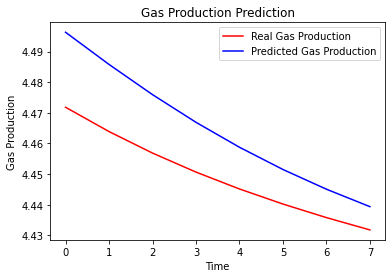

In [28]:
plt.plot(test_set, color = 'red', label = 'Real Gas Production')
plt.plot(predicted_values, color = 'blue', label = 'Predicted Gas Production')
plt.title('Gas Production Prediction')
plt.xlabel('Time')
plt.ylabel('Gas Production')
plt.legend()
plt.show()

Root Mean Square Error

In [29]:
print(np.sqrt(mean_squared_error(predicted_values,test_set)))

0.01645956530237206
